In [61]:
# ✅ Stage 1~3 전체 확률 기반 파이프라인 (CatBoost + Threshold 최적화)

from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
# -------------------------------
# 🔧 Stage별 Threshold 찾기 함수
# -------------------------------
def find_best_threshold(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1s = 2 * precision * recall / (precision + recall + 1e-8)
    best_idx = np.argmax(f1s)
    return thresholds[best_idx]

# -------------------------------
# 🧠 Stage 1: E vs Not E
# -------------------------------
def predict_stage1(models1, X_all, threshold1):
    probs1 = np.mean([model.predict_proba(X_all) for model in models1], axis=0)
    e_probs = probs1[:, 1]  # E 클래스 확률
    pred1 = (e_probs > threshold1).astype(int)
    return pred1, e_probs

# -------------------------------
# 🧠 Stage 2: C / D / CD_Others
# -------------------------------
def predict_stage2(models2, X_step2):
    probs2 = np.mean([model.predict_proba(X_step2) for model in models2], axis=0)
    pred2 = np.argmax(probs2, axis=1)  # 가장 확률 높은 클래스로 분류
    return pred2, probs2

# -------------------------------
# 🧠 Stage 3: A vs B
# -------------------------------
def predict_stage3(models3, X_step3, threshold3):
    probs3 = np.mean([model.predict_proba(X_step3) for model in models3], axis=0)
    pred3 = (probs3[:, 1] > threshold3).astype(int)
    return pred3, probs3

# -------------------------------
# 🚀 Full Prediction Pipeline
# -------------------------------
def full_pipeline(models1, models2, models3, X_all, threshold1, threshold3):
    # Stage 1
    pred1, probs1 = predict_stage1(models1, X_all, threshold1)
    idx_pred_E = np.where(pred1 == 1)[0]
    idx_not_E = np.where(pred1 == 0)[0]

    # Stage 2
    X_step2 = X_all.iloc[idx_not_E]
    pred2, probs2 = predict_stage2(models2, X_step2)
    
    idx_pred_C = idx_not_E[np.where(pred2 == 0)[0]]
    idx_pred_D = idx_not_E[np.where(pred2 == 1)[0]]
    idx_pred_CD_Others = idx_not_E[np.where(pred2 == 2)[0]]

    # Stage 3
    X_step3 = X_all.iloc[idx_pred_CD_Others]
    pred3, probs3 = predict_stage3(models3, X_step3, threshold3)

    idx_pred_A = idx_pred_CD_Others[np.where(pred3 == 0)[0]]
    idx_pred_B = idx_pred_CD_Others[np.where(pred3 == 1)[0]]

    # --------------------
    # 🧾 최종 결과 병합
    # --------------------
    final_preds = pd.Series(index=X_all.index, dtype='object')
    final_preds.loc[idx_pred_E] = 'E'
    final_preds.loc[idx_pred_C] = 'C'
    final_preds.loc[idx_pred_D] = 'D'
    final_preds.loc[idx_pred_A] = 'A'
    final_preds.loc[idx_pred_B] = 'B'

    return final_preds, {
        'stage1_probs': probs1,
        'stage2_probs': probs2,
        'stage3_probs': probs3,
    }

def run_catboost_binary_cv(X, y, cat_features, seed=12, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    models = []
    f1_scores = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
        print(f"\n🚀 Fold {fold+1} - Binary Classification Training")
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = CatBoostClassifier(
            loss_function='Logloss',
            task_type='GPU',
            random_seed=seed,
            verbose=0,
            early_stopping_rounds=100,
            auto_class_weights='Balanced'  # 불균형 클래스에 효과적
        )

        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            cat_features=cat_features,
            use_best_model=True
        )

        preds = model.predict(X_valid).astype(int).flatten()
        f1 = f1_score(y_valid, preds, average='micro')
        f1_scores.append(f1)
        print(f"✅ Fold {fold+1} F1-micro: {f1:.4f}")

        models.append(model)

    print(f"\n📊 평균 F1-micro: {np.mean(f1_scores):.4f}")
    return models

def run_catboost_multiclass_cv(X, y, cat_features, seed=12, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    models = []
    f1_scores = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
        print(f"\n🚀 Fold {fold+1} - Multiclass Training")
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = CatBoostClassifier(
            loss_function='MultiClass',
            task_type='GPU',
            random_seed=seed,
            verbose=0,
            early_stopping_rounds=100,
            auto_class_weights='Balanced'
        )

        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            cat_features=cat_features,
            use_best_model=True
        )

        preds = model.predict(X_valid).astype(int).flatten()
        f1 = f1_score(y_valid, preds, average='micro')
        f1_scores.append(f1)
        print(f"✅ Fold {fold+1} F1-micro: {f1:.4f}")

        models.append(model)

    print(f"\n📊 평균 F1-micro: {np.mean(f1_scores):.4f}")
    return models

In [62]:

# 데이터 로딩 및 전처리
df = pd.read_parquet("train_all.parquet")
cat_features = df.select_dtypes(include='object').columns.difference(['ID', 'Segment']).tolist()
label_encoder = LabelEncoder()
df['Segment_encoded'] = label_encoder.fit_transform(df['Segment'])

In [63]:
# 🔹 DataSet1: E vs Others
df_dataset1 = df.copy()
df_dataset1['target'] = (df_dataset1['Segment'] == 'E').astype(int)

X1 = df_dataset1.drop(columns=['ID', 'Segment', 'Segment_encoded', 'target'])
y1 = df_dataset1['target']
models1 = run_catboost_binary_cv(X1, y1, cat_features)


🚀 Fold 1 - Binary Classification Training
✅ Fold 1 F1-micro: 0.8856

🚀 Fold 2 - Binary Classification Training
✅ Fold 2 F1-micro: 0.8856

🚀 Fold 3 - Binary Classification Training
✅ Fold 3 F1-micro: 0.8852

🚀 Fold 4 - Binary Classification Training
✅ Fold 4 F1-micro: 0.8858

🚀 Fold 5 - Binary Classification Training
✅ Fold 5 F1-micro: 0.8864

📊 평균 F1-micro: 0.8857


In [64]:
# 🔹 DataSet2
df_dataset2 = df[~(df['Segment'] == 'E')].copy()
df_dataset2 = df_dataset2[~df_dataset2['Segment'].isin(['C', 'D']) | df_dataset2['Segment'].isin(['C', 'D'])]

# 3클래스: C(0), D(1), Others(2)
def label_stage2(seg):
    if seg == 'C':
        return 0
    elif seg == 'D':
        return 1
    else:
        return 2

df_dataset2['target'] = df_dataset2['Segment'].apply(label_stage2)

X2 = df_dataset2.drop(columns=['ID', 'Segment', 'Segment_encoded', 'target'])
y2 = df_dataset2['target']

models2 = run_catboost_multiclass_cv(X2, y2, cat_features)


🚀 Fold 1 - Multiclass Training
✅ Fold 1 F1-micro: 0.7830

🚀 Fold 2 - Multiclass Training
✅ Fold 2 F1-micro: 0.7833

🚀 Fold 3 - Multiclass Training
✅ Fold 3 F1-micro: 0.7835

🚀 Fold 4 - Multiclass Training
✅ Fold 4 F1-micro: 0.7744

🚀 Fold 5 - Multiclass Training
✅ Fold 5 F1-micro: 0.7869

📊 평균 F1-micro: 0.7822


In [65]:
# 1. A/B 데이터셋 생성
df3 = df[df['Segment'].isin(['A', 'B'])].copy()
df3['target'] = (df3['Segment'] == 'B').astype(int)
X3 = df3.drop(columns=['ID', 'Segment', 'Segment_encoded', 'target'])
y3 = df3['target']

# 2. 범주형 변수 처리 (CatBoost 용)
for col in cat_features:
    X3[col] = X3[col].astype(str)

models3 = run_catboost_binary_cv(X3, y3, cat_features)


🚀 Fold 1 - Binary Classification Training
✅ Fold 1 F1-micro: 0.9375

🚀 Fold 2 - Binary Classification Training
✅ Fold 2 F1-micro: 0.9238

🚀 Fold 3 - Binary Classification Training
✅ Fold 3 F1-micro: 0.8789

🚀 Fold 4 - Binary Classification Training
✅ Fold 4 F1-micro: 0.9193

🚀 Fold 5 - Binary Classification Training
✅ Fold 5 F1-micro: 0.9552

📊 평균 F1-micro: 0.9229


In [66]:
# Stage 1
preds1_probs = np.mean([model.predict_proba(X1) for model in models1], axis=0)
best_threshold1 = find_best_threshold(y1, preds1_probs[:, 1])

# Stage 3
preds3_probs = np.mean([model.predict_proba(X3) for model in models3], axis=0)
best_threshold3 = find_best_threshold(y3, preds3_probs[:, 1])

In [67]:
X_all = df.drop(columns=['ID', 'Segment', 'Segment_encoded'])
final_preds, all_probs = full_pipeline(models1, models2, models3, X_all, best_threshold1, best_threshold3)

In [68]:
print(final_preds.value_counts())

E    1965729
D     257825
C     166426
A       9428
B        592
Name: count, dtype: int64


In [69]:
from sklearn.metrics import f1_score

# 실제 라벨
y_true = df['Segment'].values
# 예측 라벨
y_pred = final_preds.values

# F1-micro 계산
f1 = f1_score(y_true, y_pred, average='micro')
print(f"🎯 최종 F1-micro: {f1:.4f}")

🎯 최종 F1-micro: 0.8763


c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


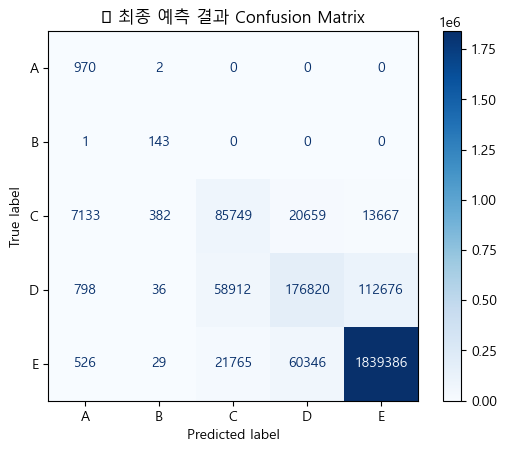

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
# 기본 한글 폰트 설정 (Windows 사용자는 Malgun Gothic 추천)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 실제값과 예측값
y_true = df['Segment']
y_pred = final_preds

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred, labels=['A', 'B', 'C', 'D', 'E'])

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'B', 'C', 'D', 'E'])
disp.plot(cmap='Blues', values_format='d')
plt.title("✅ 최종 예측 결과 Confusion Matrix")
plt.show()

In [72]:
# 실제값과 예측값
y_true = df['Segment']
y_pred = final_preds

# 모든 Segment class 확인
segments = sorted(y_true.unique())

# 정리할 결과 저장할 리스트
results = []

for seg in segments:
    idx = (y_true == seg)
    total = idx.sum()
    correct = (y_true[idx] == y_pred[idx]).sum()
    incorrect = total - correct
    correct_ratio = correct / total
    incorrect_ratio = incorrect / total
    results.append({
        'Segment': seg,
        'Total': total,
        'Correct': correct,
        'Incorrect': incorrect,
        'Accuracy(%)': round(correct_ratio * 100, 2),
        'Misclass(%)': round(incorrect_ratio * 100, 2)
    })

# 결과를 DataFrame으로 보기 좋게 정리
accuracy_df = pd.DataFrame(results)
print(accuracy_df)

  Segment    Total  Correct  Incorrect  Accuracy(%)  Misclass(%)
0       A      972      970          2        99.79         0.21
1       B      144      143          1        99.31         0.69
2       C   127590    85749      41841        67.21        32.79
3       D   349242   176820     172422        50.63        49.37
4       E  1922052  1839386      82666        95.70         4.30
